In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix,
    plot_confusion_matrix, make_scorer,multilabel_confusion_matrix,ConfusionMatrixDisplay)

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.dummy import DummyClassifier

import warnings

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')

rng = 2308168484 #int(np.random.default_rng().random()*(2**32))

%matplotlib inline
%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
df = pd.read_csv(data_processed_dir+'processed_data_weekly_class.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date', ascending=False)
df.head(2)

,date,Total US RigCount,wti_spot_lag_15,wti_spot_lag_9,wti_spot,brent_spot,wti_fut_1,wti_fut_2,wti_fut_3,wti_fut_4,...,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons,rig_change_4bin_week+4,rig_change_4bin_week+8,rig_pct_change_week+4,rig_pct_change_week+8
0,2020-08-14,172.0,23.464,37.872,42.076,44.538,42.094,42.364,42.692,42.996,...,37.872,42.782417,37.872,51.707156,37.872,94.489573,++,++,0.046512,0.122093
1,2020-08-07,176.0,15.712,37.322,41.568,44.356,41.614,41.868,42.214,42.514,...,37.322,42.807514,37.322,51.382073,37.322,94.189587,++,++,0.028409,0.073864


In [4]:
num_col_rig_change = df.columns.str.contains('rig_').sum()

df.columns

Index(['date', 'Total US RigCount', 'wti_spot_lag_15', 'wti_spot_lag_9',
       'wti_spot', 'brent_spot', 'wti_fut_1', 'wti_fut_2', 'wti_fut_3',
       'wti_fut_4', 'usa_net_import_smooth', 'usa_net_import',
       'usa_stocks_all', 'usa_stocks_spr', 'usa_l48_prod_smooth',
       'usa_l48_prod', 'opec_tot_prod', 'opec_crud_capac', 'opec_surp_capac',
       'non-opec_tot_prod', 'oecd_cons_smooth', 'oecd_cons',
       'non-oecd_cons_smooth', 'non-oecd_cons', 'world_cons_smooth',
       'world_cons', 'rig_change_4bin_week+4', 'rig_change_4bin_week+8',
       'rig_pct_change_week+4', 'rig_pct_change_week+8'],
      dtype='object')

In [5]:
df = df.drop(['brent_spot','wti_fut_1','wti_fut_2','wti_fut_3','wti_fut_4','usa_l48_prod','world_cons_smooth','world_cons','oecd_cons','non-oecd_cons','non-oecd_cons_smooth','usa_stocks_all'],axis=1)

In [6]:
df = df.drop(['wti_spot_lag_15','wti_spot_lag_9'],axis=1)

In [7]:
df.shape

(498, 16)

## Train Test Split
Define features X, and target variable y

In [8]:
X = pd.concat([df.iloc[:,2:-num_col_rig_change],df[df.columns[df.columns.str.contains('rig_pct')]]],axis=1)
y = df.loc[:,'rig_change_4bin_week+8']

old_class = ['--','-','+','++']
new_class = [int(0),int(1),int(2),int(3)]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=rng)

pct_change_train = X_train[X_train.columns[X_train.columns.str.contains('rig_pct')]]
pct_change_test = X_test[X_train.columns[X_train.columns.str.contains('rig_pct')]]

X_train = X_train[X_train.columns[~X_train.columns.str.contains('rig_pct')]]

X_test = X_test[X_train.columns[~X_train.columns.str.contains('rig_pct')]]

X = df.iloc[:,2:-num_col_rig_change]

model_score = pd.DataFrame(columns=['accuracy','balanced accuracy','precision avg','recall avg','precision (++)','precision (+)','precision (-)','precision (--)','recall (++)','recall (+)','recall (-)','recall (--)','pos neg class','max depth'])

In [9]:
# Define functions
def add_model_score(model,model_name,y_test,y_pred):
    model_score.loc[model_name,'accuracy'] = accuracy_score(y_test,y_pred)    
    model_score.loc[model_name,'balanced accuracy'] = balanced_accuracy_score(y_test,y_pred)
    
    precision_arr = precision_score(y_test,y_pred,average=None,labels=['++','+','-','--'])
    recall_arr = recall_score(y_test,y_pred,average=None,labels=['++','+','-','--'])
    
    precision_arr_weight = precision_score(y_test,y_pred,average='weighted',labels=['++','+','-','--']) 
    recall_arr_weight = recall_score(y_test,y_pred,average='weighted',labels=['++','+','-','--'])
    
    model_score.loc[model_name,'precision avg'] = precision_arr_weight
    model_score.loc[model_name,'recall avg'] = recall_arr_weight
    
    model_score.loc[model_name,'precision (++)'] = precision_arr[0]
    model_score.loc[model_name,'precision (+)'] = precision_arr[1]
    model_score.loc[model_name,'precision (-)'] = precision_arr[2]
    model_score.loc[model_name,'precision (--)'] = precision_arr[3]
    
    model_score.loc[model_name,'recall (++)'] = recall_arr[0]
    model_score.loc[model_name,'recall (+)'] = recall_arr[1]
    model_score.loc[model_name,'recall (-)'] = recall_arr[2]
    model_score.loc[model_name,'recall (--)'] = recall_arr[3]
    
    model_score.loc[model_name,'pos neg class'] = scorer_pos_neg_class(y_test,y_pred)
    
    if ('RFC' in model_name) or ('XGB' in model_name):
        
        if ~('base' in model_name):
            model_score.loc[model_name,'max depth'] = model.best_estimator_.named_steps.model.max_depth
        else:
            model_score.loc[model_name,'max depth'] = np.nan
    else : 
        model_score.loc[model_name,'max depth'] = np.nan
    
    return model_score[model_score.index == model_name]
    
def feat_imp(model):
    plt.subplots(figsize=(10, 5))
    imps = model.best_estimator_.named_steps.model.feature_importances_
    rf_feat_imps = pd.Series(imps, index=X.columns).sort_values(ascending=False)
    rf_feat_imps.plot(kind='bar')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Best feature importances');
    
    return plt.show()

def scorer_pos_neg_class(y_test,y_pred):
    mat_conf = confusion_matrix(y_test,y_pred)

    pos_2_neg = mat_conf[[0,1],2:].sum()
    neg_2_pos = mat_conf[[2,3],:2].sum()

    pos_neg_misclass = 1-(pos_2_neg+neg_2_pos)/mat_conf.sum()
    
    return pos_neg_misclass

def scorer_confusion_matrix(y_test,y_pred):
    return confusion_matrix(y_test,y_pred)

recall_neg_scorer = make_scorer(recall_score,average=None,labels=['-'],greater_is_better=True)
pos_neg_class_scorer = make_scorer(scorer_pos_neg_class,greater_is_better=True)

confusion_matrix_scorer = make_scorer(scorer_confusion_matrix)

In [10]:
from joblib import dump, load

model = load('best_model.joblib')

y_pred = model.predict(X_test)

add_model_score(model,'RFC_base_import',y_test,y_pred)

C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid 

,accuracy,balanced accuracy,precision avg,recall avg,precision (++),precision (+),precision (-),precision (--),recall (++),recall (+),recall (-),recall (--),pos neg class,max depth
RFC_base_import,0.854545,0.851807,0.857781,0.854545,0.886364,0.851064,0.735294,0.925,0.906977,0.833333,0.806452,0.860465,0.963636,None


# Review of model mis-classifications

## True '+', Predicted '-'

In [11]:
y_comb = pd.concat([y_test,pd.Series(y_pred,index=y_test.index),pct_change_test['rig_pct_change_week+8']],ignore_index=True,axis=1)
y_comb.columns = ['test','pred','pct_change']

df_quantiles = pd.DataFrame(pd.read_csv(data_processed_dir+'quantiles.csv',index_col=0).loc['week+8',:])

def misclass_check(y_comb,test_val,pred_val):
    misclass = y_comb[(y_comb.test == test_val) & (y_comb.pred == pred_val)]
    
    inc_index = y_comb[(y_comb.test == test_val) & (y_comb.pred == pred_val)].sort_index().index.to_list()
    
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(df.date,df['Total US RigCount'],c='b',alpha=0.5,label='Rig Count Data')
    ax.scatter(df.date[inc_index],df['Total US RigCount'][inc_index],c='r',alpha=1,s=10,label='data')
    ax.scatter(df.date[[x-8 for x in inc_index]],df['Total US RigCount'][[x-8 for x in inc_index]],c='g',alpha=1,s=10,label='predicted')

    ax.legend()
    
    plt.show()
    
    return misclass

df_quantiles

,week+8
25%,-0.033334
50%,0.009174
75%,0.054922


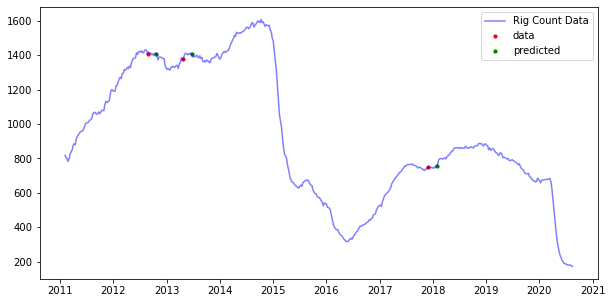

,test,pred,pct_change
141,+,-,0.013351
416,+,-,0.001420
381,+,-,0.017379


In [12]:
misclass_check(y_comb,'+','-')

Index 461 is a very small increase, close to zero. Indeces 141 and 381 are farther away from zero but close to zero. Again, not a very significant issue for these borderline classifications.

#### True '-', Predicted '+'

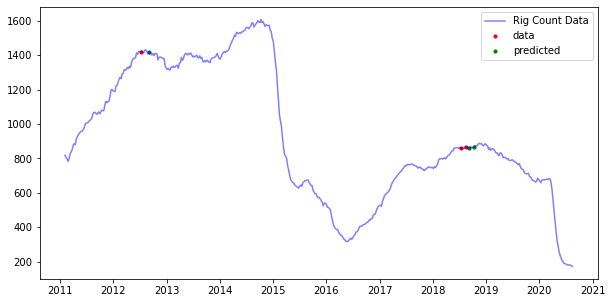

,test,pred,pct_change
109,-,+,-0.003476
423,-,+,0.000000
104,-,+,0.000000


In [13]:
misclass_check(y_comb,'-','+')

Indeces 104 and 423 have no change. Index 423 is less than a percent decrease. These misclassifications are very close to the border between class bins.

#### True '++', Predicted '+'

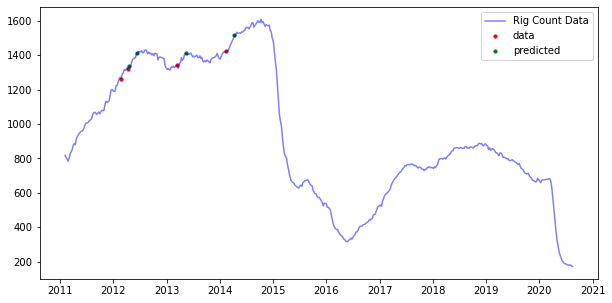

,test,pred,pct_change
435,++,+,0.069592
387,++,+,0.052946
442,++,+,0.056917
339,++,+,0.066058


In [14]:
misclass_check(y_comb,'++','+')

Cut off for the '+', '++' bins is 5.2%. Most of these are very close to the border. It is a little disconcerting that they are all grouped at the same point in before 2015, however, this does not seem to affect the later points.

#### True '+', Predicted '++'

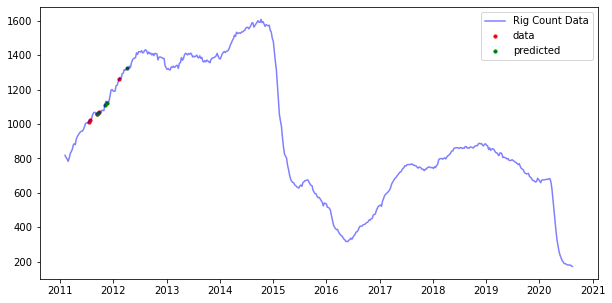

,test,pred,pct_change
464,+,++,0.050420
473,+,++,0.040157
466,+,++,0.052034
444,+,++,0.052257
474,+,++,0.043435


In [15]:
misclass_check(y_comb,'+','++')

Again most of these points are very close to the border between '+' and '++'. Only #473 is greater than 1 point from the border. Again, a little troubling that these are all bunched near the early dates.

#### True '--', Predicted '-'

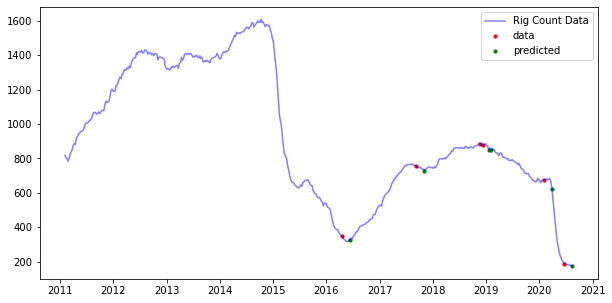

,test,pred,pct_change
153,--,-,-0.035714
90,--,-,-0.037288
28,--,-,-0.075556
88,--,-,-0.034208
226,--,-,-0.065527
8,--,-,-0.089947


In [16]:
misclass_check(y_comb,'--','-')

Three of these points (153, 90, 88) are borderline cases close to the bin separation point (-0.033). However, there are a few cases where steep declines were predicted as only slight declines (8, 28, 226). This is a bit more troubling however, it is important to note that the vast majority of these "steep" declines were predicted correctly.

#### True '-', Predicted '--'

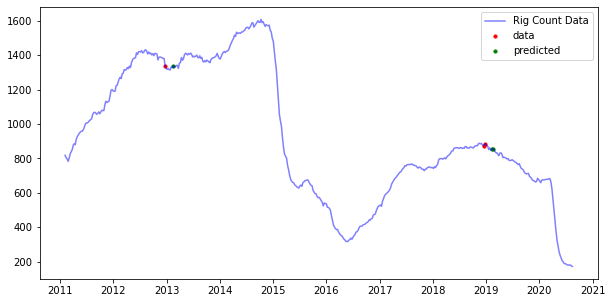

,test,pred,pct_change
87,-,--,-0.021764
86,-,--,-0.029445
399,-,--,-0.002239


In [17]:
misclass_check(y_comb,'-','--')

Three points were not predicted properly. 86 and 87 are adjacent and most likely there's a characteristic that they share that caused this misclassification. 399 however is troubling, as the change is less than 1%, however it is predicted as being greater than 3%.

# How does it perform on recent data?

In [18]:
df_full = pd.read_csv(data_processed_dir+'processed_weekly_class_full.csv',parse_dates=True)

df_part = df_full.copy()

In [21]:
shifts= [8]

for ii in shifts:
    df_part['rig_fut_week+'+str(ii)] = df_part.copy()['Total US RigCount'].shift(ii)
    
    df_part['rig_pct_change_week+'+str(ii)] = (df_part['rig_fut_week+'+str(ii)]-df_part['Total US RigCount'])/(df_part['Total US RigCount'])

    
    df_part['rig_change_4bin_week+'+str(ii)] = pd.cut(df_part['rig_pct_change_week+'+str(ii)],bins=[df_part['rig_pct_change_week+'+str(ii)].min()-0.01,df_quantiles.loc['25%','week+'+str(ii)],0,df_quantiles.loc['75%','week+'+str(ii)],df_part['rig_pct_change_week+'+str(ii)].max()+0.01],labels=['--','-','+','++'])
    
df_part.loc[:,['date','Total US RigCount','rig_fut_week+8','rig_pct_change_week+8','rig_change_4bin_week+8']].head(10)

,date,Total US RigCount,rig_fut_week+8,rig_pct_change_week+8,rig_change_4bin_week+8
0,2020-11-06,226.0,NaN,NaN,NaN
1,2020-10-30,221.0,NaN,NaN,NaN
2,2020-10-23,211.0,NaN,NaN,NaN
3,2020-10-16,205.0,NaN,NaN,NaN
4,2020-10-09,193.0,NaN,NaN,NaN
5,2020-10-02,189.0,NaN,NaN,NaN
6,2020-09-25,183.0,NaN,NaN,NaN
7,2020-09-18,179.0,NaN,NaN,NaN
8,2020-09-11,180.0,226.0,0.255556,++
9,2020-09-04,181.0,221.0,0.220994,++


<ipython-input-24-ff82555f1a98>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part = df_part.copy()[df_full.date > str(df.date[0])].dropna()


,date,Cana Woodford,DJ-Niobrara,Eagle Ford,Permian,Williston,Total US RigCount,wti_spot_lag_15,wti_spot_lag_9,wti_spot,...,non-opec_tot_prod,oecd_cons_smooth,oecd_cons,non-oecd_cons_smooth,non-oecd_cons,world_cons_smooth,world_cons,rig_fut_week+8,rig_pct_change_week+8,rig_change_4bin_week+8
8,2020-09-11,6.0,4.0,9.0,122.0,9.0,180.0,37.322,40.442,37.375,...,62.924340,40.442,43.128099,40.442,52.340763,40.442,95.468862,226.0,0.255556,++
9,2020-09-04,6.0,4.0,9.0,124.0,9.0,181.0,34.185,39.992,41.842,...,62.854913,39.992,42.840947,39.992,52.482387,39.992,95.323334,221.0,0.220994,++
10,2020-08-28,6.0,4.0,9.0,124.0,10.0,180.0,33.096,39.220,42.932,...,62.805609,39.220,42.732223,39.220,52.357322,39.220,95.089545,211.0,0.172222,++
11,2020-08-21,6.0,4.0,9.0,126.0,10.0,183.0,26.398,38.350,42.726,...,62.771396,38.350,42.757320,38.350,52.032239,38.350,94.789559,205.0,0.120219,++


In [25]:
df_part = df_part.copy()[df_full.date > str(df.date[0])].dropna()
X_part = df_part[X_train.columns.to_list()]
X_part

<ipython-input-25-442a545bcf03>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_part = df_part.copy()[df_full.date > str(df.date[0])].dropna()


,wti_spot,usa_net_import_smooth,usa_net_import,usa_stocks_spr,usa_l48_prod_smooth,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons_smooth
8,37.375,2.33575,2.413,645.733,9.875,29.108107,31.634444,7.374444,62.924340,40.442
9,41.842,2.63075,2.479,647.860,9.850,28.944599,31.602749,7.514249,62.854913,39.992
10,42.932,2.63050,1.898,648.165,10.050,28.862164,31.581962,7.576639,62.805609,39.220
11,42.726,2.95375,2.553,649.465,10.400,28.840532,31.569355,7.580968,62.771396,38.350


In [26]:
y_part = df_part['rig_change_4bin_week+8']
y_part

8     ++
9     ++
10    ++
11    ++
Name: rig_change_4bin_week+8, dtype: category
Categories (4, object): ['--' < '-' < '+' < '++']

In [27]:
y_pred = model.predict(X_part)